## 결정 트리 실습 - 사용자 행동 인식 데이터 세트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 'features.txt' 파일에는 피처 이름 인덱스와 피처명이 공백으로 분리되어있음
# 이를 DF로 로드
feature_name_df = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])

# 피처명 인덱스 제거, 피처명만 리스트 객체로 생성
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
# 중복된 피처명이 얼마나 있는지 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name']= new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                             if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [19]:
import pandas as pd

def get_human_datasets():
    feature_name_df = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\features.txt', sep='\s+',
                             header=None, names=['column_index', 'column_name'])
    
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\train\X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\test\X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\train\y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv(r'C:\Users\splen\Desktop\human_activity\test\y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_datasets()

print('학습 피처 데이터셋 info()')
print(X_train.info())

학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [20]:
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [21]:
# DecisionTreeClassifier로 동착 예측 분류 수행
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)

# 학습
dt_clf.fit(X_train, y_train)

# 예측
pred = dt_clf.predict(X_test)

# 정확도 구하기
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


#### 결정 트리의 depth가 예측 정확도에 주는 영향 살펴보기

In [23]:
from sklearn.model_selection import GridSearchCV

# 최대 깊이 6, 8, ... 로 변화시키면서 예측 성능 확인
params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24],
    'min_samples_split' : [16]  # 고정값
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [25]:
# cv_results_ : CV 세트에서 하이퍼 파라미터를 순차적으로 입력했을 때의 성능 수치
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


#### 별도의 테스트 데이터 세트에서 결정 트리 정확도 측정

In [26]:
max_depths = [6, 8, 10, 12, 16, 20, 24]

# max_depth값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


#### max_depth와 min_samples_split 같이 변화시키면서 정확도 성능 튜닝

In [27]:
params = {
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [16, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_split': 16}


In [28]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


#### 결정 트리에서 각 피처의 중요도: feature_importances_

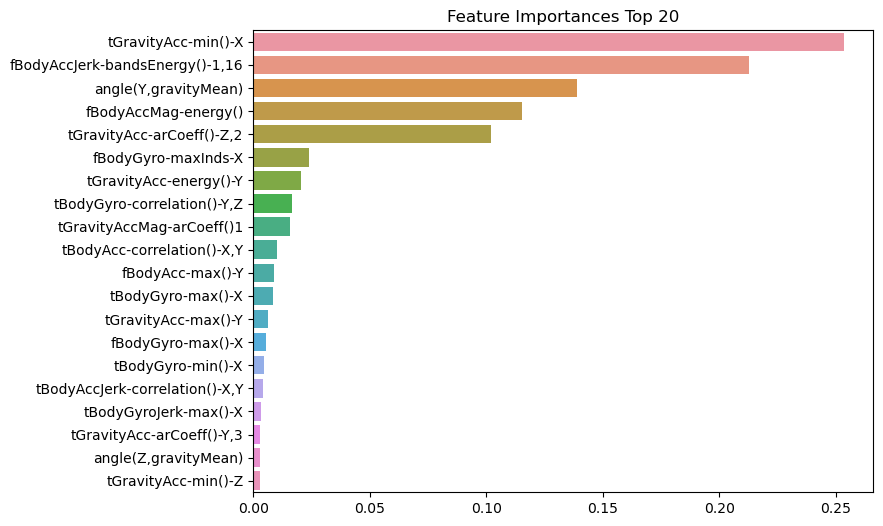

In [29]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()